# Analysis of the Distribution of the Data

The following analysis is a exploration of the distribution of the data based of multiple variables.

## 0. Imports

In [217]:
%pip install numpy pandas matplotlib seaborn requests scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

## 1. Cleaning the Data

In [219]:
data = pd.read_csv('data/data.csv')

/var/folders/7_/3hb05gd9671d9pqxmcszwzw80000gn/T/ipykernel_1095/518131353.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/data.csv')


In [220]:
# Drop not used columns 'codigoOC', 'NroLicitacion', 'NombreOC', 'ProveedorRUT', 'RubroN1', 'RubroN2', 'RubroN3'
data = data.drop(columns=['codigoOC', 'NroLicitacion', 'NombreOC', 'ProveedorRUT', 'RubroN1', 'RubroN2', 'RubroN3'])

In [221]:
# Clean the 0 values of 'CantidadItem' column, replace with 1
data['CantidadItem'] = data['CantidadItem'].replace(0, 1)

In [222]:
# Check the Precio_Unitario_TOTAL given the value was 0

### 1.1 Based on Products
The following analysis is on the variable of CodigoProductoONU, refering to as the code of the **United Nations Standard Products and Services Code (UNSPSC)**.

In [223]:
unspsc_data = pd.read_csv('data/clean_unspsc_data.csv')

### 1.1.1 Clean the Data based on MonedaItem

In [224]:
# Filter the data to only use MonedaItem == 'CLP'
clp_data = data[data['MonedaItem'] == 'CLP']

### 1.1.2 Encode the Categorical Data

In [225]:
# One-hot encode the 'EstadoOC', 'RegionUnidadCompra', 'TamanoProveedor', 'MonedaItem' columns
clp_data = pd.get_dummies(clp_data, columns=['EstadoOC', 'RegionUnidadCompra', 'TamanoProveedor', 'MonedaItem'], drop_first=True)

### 1.2 Calculate the Percentils and add K-Fold Target Encoding

In [226]:
# Calculate the percentils of Precio_Unitario_TOTAL for every CodigoProductoONU
for code in clp_data['CodigoProductoONU'].unique():
    code_data = clp_data[clp_data['CodigoProductoONU'] == code]
    percentiles = code_data['Precio_Unitario_TOTAL'].describe(percentiles=[.80])
    
    # Every row that is over the 80th percentile is considered expensive
    threshold = percentiles['80%']
    clp_data.loc[(clp_data['CodigoProductoONU'] == code) & (clp_data['Precio_Unitario_TOTAL'] > threshold), 'is_expensive'] = True
    clp_data.loc[(clp_data['CodigoProductoONU'] == code) & (clp_data['Precio_Unitario_TOTAL'] <= threshold), 'is_expensive'] = False
    clp_data['is_expensive'] = clp_data['is_expensive'].fillna(False)
    clp_data['is_expensive'] = clp_data['is_expensive'].astype(bool)

/var/folders/7_/3hb05gd9671d9pqxmcszwzw80000gn/T/ipykernel_1095/1524213012.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clp_data['is_expensive'] = clp_data['is_expensive'].fillna(False)
/Users/ignaciopalma/Desktop/Code/transparenta/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/ignaciopalma/Desktop/Code/transparenta/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/ignaciopalma/Desktop/Code/transparenta/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr =

In [227]:
# K-Fold target encoding on 'Financiamiento', 'UnidadCompra', 'Institucion', 'Proveedor', 'RegionProveedor', 'NombreItem' columns
def kfold_target_encoding(data, column, target, n_splits=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded_column = pd.Series(index=data.index, dtype=float)

    for train_index, val_index in kf.split(data):
        train_data, val_data = data.iloc[train_index], data.iloc[val_index]
        means = train_data.groupby(column)[target].mean()
        encoded_column.iloc[val_index] = val_data[column].map(means)

    return encoded_column

for col in ['Financiamiento', 'UnidadCompra', 'Institucion', 'Proveedor', 'RegionProveedor', 'NombreItem']:
    clp_data[f'{col}_encoded'] = kfold_target_encoding(clp_data, col, 'is_expensive')

In [228]:
# Drop the original categorical columns after encoding
clp_data = clp_data.drop(columns=['Financiamiento', 'UnidadCompra', 'Institucion', 'Proveedor', 'RegionProveedor', 'NombreItem'])

### 1.3 Scale the Data

In [229]:
# Scale the Data
from sklearn.preprocessing import StandardScaler

# Check for infinity and NaN values
print("Checking for problematic values:")
print(f"NaN values: {clp_data.isna().sum().sum()}")
print(f"Infinity values: {np.isinf(clp_data.select_dtypes(include=[np.number])).sum().sum()}")


Checking for problematic values:
NaN values: 136820
Infinity values: 193


In [230]:
# Fill NaN values from target encoding with the global mean
for col in ['Financiamiento_encoded', 'UnidadCompra_encoded', 'Institucion_encoded', 
            'Proveedor_encoded', 'RegionProveedor_encoded', 'NombreItem_encoded']:
    if col in clp_data.columns:
        clp_data[col] = clp_data[col].fillna(clp_data[col].mean())


In [231]:
# Check for infinity and NaN values
print("Checking for problematic values:")
print(f"NaN values: {clp_data.isna().sum().sum()}")
print(f"Infinity values: {np.isinf(clp_data.select_dtypes(include=[np.number])).sum().sum()}")

Checking for problematic values:
NaN values: 8
Infinity values: 193


In [232]:
# Replace infinity values with NaN, then fill with column mean
clp_data = clp_data.replace([np.inf, -np.inf], np.nan)
clp_data = clp_data.fillna(clp_data.mean(numeric_only=True))

In [ ]:
# Now scale the data

# Scale only the numerical columns, not booleans, and ignore the 'CodigoProductoONU' column
numerical_cols = clp_data.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('CodigoProductoONU', errors='ignore')

scaler = StandardScaler()
clp_data_scaled = clp_data.copy()
clp_data_scaled[numerical_cols] = scaler.fit_transform(clp_data_scaled[numerical_cols])
print("\nScaling completed successfully!")


Scaling completed successfully!


## 2. Data Visualization

### 2.1 PCA Analysis

In [234]:
from sklearn.decomposition import PCA

# Make a copy for the PCA without CodigoProductoONU
clp_data_pca_ready = clp_data_scaled.drop(columns=['CodigoProductoONU'], errors='ignore')

pca = PCA()
pca.fit(clp_data_pca_ready)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


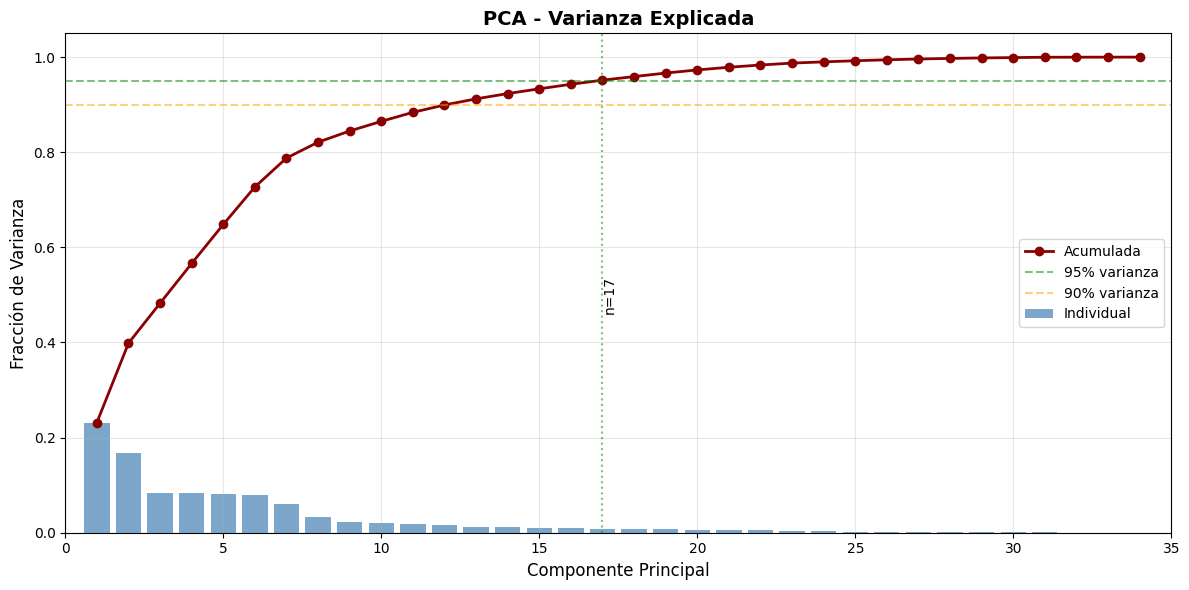


Resumen de PCA:
Total de componentes: 34
Componentes para 90% varianza: 13
Componentes para 95% varianza: 17
Componentes para 99% varianza: 24

Primeras 5 componentes explican: 64.81% de la varianza
Primeras 10 componentes explican: 86.49% de la varianza



In [235]:
exp_var = pca.explained_variance_ratio_
cum_exp = np.cumsum(exp_var)
k = len(exp_var)

# Improved PCA variance plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Scree plot with better styling
ax1.bar(range(1, k+1), exp_var, alpha=0.7, color='steelblue', label="Individual")
ax1.plot(range(1, k+1), cum_exp, marker="o", color='darkred', linewidth=2, 
         markersize=6, label="Acumulada")

# Add horizontal lines for reference
ax1.axhline(y=0.95, color='green', linestyle='--', alpha=0.5, label='95% varianza')
ax1.axhline(y=0.90, color='orange', linestyle='--', alpha=0.5, label='90% varianza')

# Find number of components for 95% variance
n_components_95 = np.argmax(cum_exp >= 0.95) + 1
ax1.axvline(x=n_components_95, color='green', linestyle=':', alpha=0.5)
ax1.text(n_components_95, 0.5, f'n={n_components_95}', rotation=90, 
         verticalalignment='center')

ax1.set_xlabel("Componente Principal", fontsize=12)
ax1.set_ylabel("Fracción de Varianza", fontsize=12)
ax1.set_title("PCA - Varianza Explicada", fontsize=14, fontweight='bold')
ax1.legend(loc='center right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, k+1)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"Resumen de PCA:")
print(f"{'='*60}")
print(f"Total de componentes: {k}")
print(f"Componentes para 90% varianza: {np.argmax(cum_exp >= 0.90) + 1}")
print(f"Componentes para 95% varianza: {n_components_95}")
print(f"Componentes para 99% varianza: {np.argmax(cum_exp >= 0.99) + 1}")
print(f"\nPrimeras 5 componentes explican: {cum_exp[4]:.2%} de la varianza")
print(f"Primeras 10 componentes explican: {cum_exp[9]:.2%} de la varianza")
print(f"{'='*60}\n")

In [213]:
# Transform data to first 18 components
pca_18 = PCA(n_components=18)
clp_data_pca18 = pca_18.fit_transform(clp_data_scaled)

print(f"Transformed data shape: {clp_data_pca18.shape}")
print(f"Variance explained by 18 components: {pca_18.explained_variance_ratio_.sum():.2%}")

Transformed data shape: (700751, 18)
Variance explained by 18 components: 100.00%


### 2.2 Distribution Plots

In [236]:
clp_data_scaled

,MontoTotalOC,CodigoProductoONU,CantidadItem,MontoTotalItem,Precio_Unitario_TOTAL,EstadoOC_En Proceso,EstadoOC_Enviada a Proveedor,EstadoOC_Recepcion Conforme,EstadoOC_Solicitud de Cancelacion,RegionUnidadCompra_Region Metropolitana de Santiago,...,TamanoProveedor_Micro,TamanoProveedor_NoClasificado,TamanoProveedor_Pequeña,is_expensive,Financiamiento_encoded,UnidadCompra_encoded,Institucion_encoded,Proveedor_encoded,RegionProveedor_encoded,NombreItem_encoded
0,-0.035396,50202304,-0.001448,-0.019838,-0.018113,False,False,False,False,False,...,False,True,False,False,-0.445772,-0.876091,-0.924046,-1.169232,-0.997933,0.033721
1,-0.032310,93131607,-0.001455,-0.019597,-0.017437,False,False,False,False,False,...,False,False,True,False,0.125444,-0.274848,-0.227971,-0.290232,-0.550388,0.176699
2,-0.032310,93131607,-0.001455,-0.020078,-0.018088,False,False,False,False,False,...,False,False,True,False,0.146576,-0.276984,-0.248224,-0.313650,-0.539310,0.098268
3,-0.032310,93131607,-0.001429,-0.019597,-0.018115,False,False,False,False,False,...,False,False,True,False,0.146994,-0.266099,-0.168057,-0.333912,-0.504379,0.121282
4,-0.033210,14111531,-0.001454,-0.020067,-0.018107,False,False,True,False,False,...,False,False,True,False,-1.295377,-0.457236,-0.446293,-0.320559,0.399380,-0.062533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703175,-0.035416,50181905,-0.001455,-0.020026,-0.018079,False,False,True,False,False,...,False,True,False,True,-0.317819,-0.116094,-0.357771,0.074527,-0.071902,-0.059511
703176,-0.035416,50181905,-0.001454,-0.020033,-0.018105,False,False,True,False,False,...,False,True,False,False,0.529398,0.141883,-0.319347,0.009925,-0.106335,0.003880
703177,-0.034450,44111804,-0.001455,-0.019885,-0.018009,False,False,True,False,False,...,False,False,False,False,0.020566,0.187346,-0.197145,0.040983,-0.511865,-0.076037
703178,-0.034450,44121612,-0.001455,-0.020095,-0.018101,False,False,True,False,False,...,False,False,False,False,0.059654,0.141883,-0.319347,-0.015162,-0.504379,-0.298093


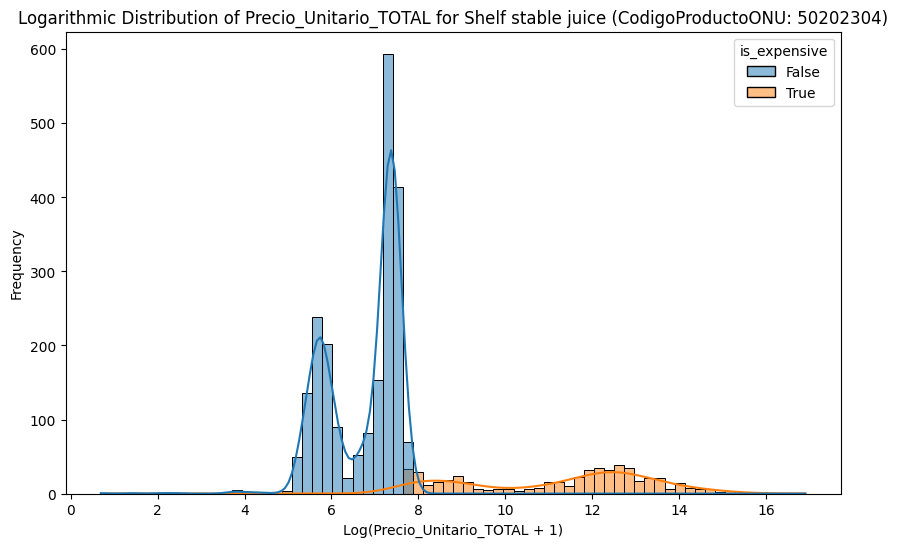

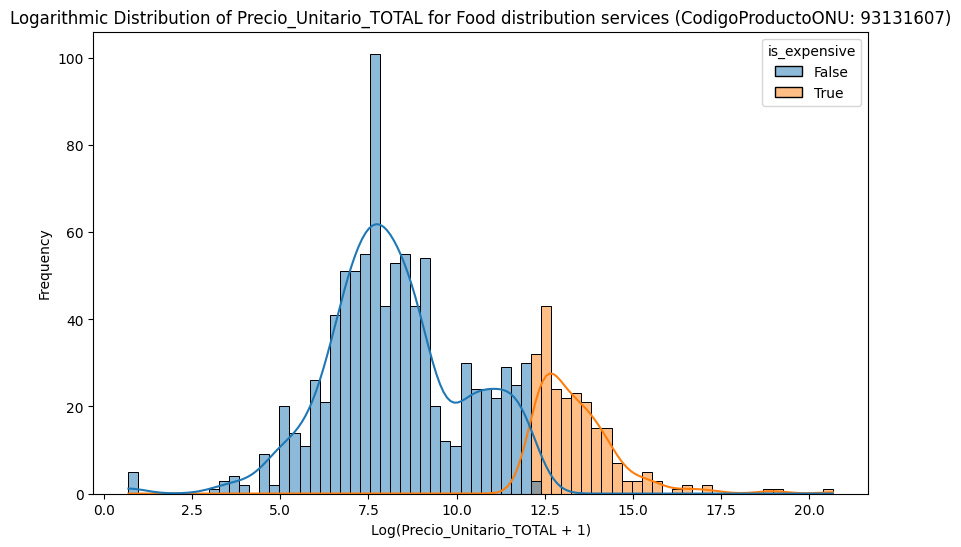

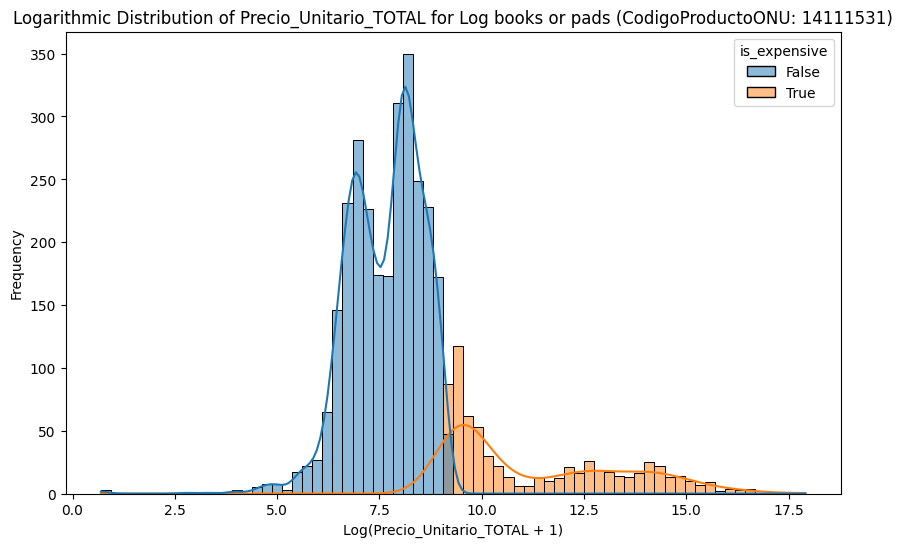

In [238]:
# For the first three CodigoProductoONU, plot the logaritmic distribution of Precio_Unitario_TOTAL
# Remembering to marking the expensive one
for code in clp_data['CodigoProductoONU'].unique()[:3]:
    code_data = clp_data[clp_data['CodigoProductoONU'] == code]
    plt.figure(figsize=(10, 6))
    sns.histplot(data=code_data, x=np.log1p(code_data['Precio_Unitario_TOTAL']), bins=70, hue='is_expensive', kde=True)

    # Using unspsc_data to get the name of the CodigoProductoONU
    product_name = unspsc_data[unspsc_data['Commodity Code'] == code]['Commodity Name'].values[0]
    plt.title(f'Logarithmic Distribution of Precio_Unitario_TOTAL for {product_name} (CodigoProductoONU: {code})')
    plt.xlabel('Log(Precio_Unitario_TOTAL + 1)')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Download data
clp_data_scaled.to_csv('data/data_with_expensive_flag_scaled.csv', index=False)